# Load Frequency Control

This examples shows (1) how to trip a generator, and (2) how to drive frequency back by load shedding.

In [1]:
import andes
import numpy as np

andes.config_logger(stream_level=20)

## Tripping a Generator in the IEEE 14-Bus System

In [2]:
# using the IEEE 14-bus model as an example. 
# The example here contains a variety of models: generators, exciters, turbine governors, and PSS
# To speed up, one can remove unneeded ones, e.g., PSS

ieee14_raw = andes.get_case("ieee14/ieee14.raw")
ieee14_dyr = andes.get_case("ieee14/ieee14.dyr")

In [3]:
# use `andes.load` to load the test system
# Need to set `setup=False` to be able to add new Toggles that turns off generators.

ss = andes.load(ieee14_raw, addfile=ieee14_dyr, setup=False)

Working directory: "/home/hacui/repos/andes/examples"
> Loaded config from file "/home/hacui/.andes/andes.rc"
> Loaded generated Python code in "/home/hacui/.andes/pycode".
Parsing input file "/home/hacui/repos/andes/andes/cases/ieee14/ieee14.raw"...
  IEEE 14 BUS TEST CASE
  03/06/14 CONTO           100.0  1962 W
Input file parsed in 0.0119 seconds.
Parsing additional file "/home/hacui/repos/andes/andes/cases/ieee14/ieee14.dyr"...
Addfile parsed in 0.2965 seconds.


In [4]:
# Add a Toggle that disconnects `GENROU_2` at t=1 s

ss.add("Toggle", dict(model='SynGen', dev="GENROU_2", t=1.0))

'Toggle_3'

In [5]:
# Call setup manually

ss.setup()

IEEEST <IEEEST_1> added BusFreq <BusFreq_1> linked to bus <3.0>
ST2CUT <ST2CUT_2> added BusFreq <BusFreq_2> linked to bus <1.0>
ST2CUT <ST2CUT_3> added BusFreq <BusFreq_3> linked to bus <2.0>
System internal structure set up in 0.0750 seconds.


True

In [6]:
# double check that Toggles are set up correctly
# Check `u` of the Toggles - the first two line switches are disabled, and the generator trip is enabled

ss.Toggle.as_df()

,idx,u,name,model,dev,t
uid,,,,,,
0,Toggle_1,1.0,Toggle_1,Line,Line_1,1.0
1,Toggle_2,1.0,Toggle_2,Line,Line_1,1.1
2,Toggle_3,1.0,Toggle_3,SynGen,GENROU_2,1.0


In [7]:
# disable existing line switches
# The IEEE 14-bus system contains predefined line switches. Disabling them to study generator trip only.

ss.Toggle.u.v[[0, 1]] = 0

In [8]:
# calculate power flow

# use constant power model for PQ (we will come back to this later)

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0

ss.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0101 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382824e-06
3: |F(x)| = 6.96508129e-12
Converged in 4 iterations in 0.0111 seconds.
Initialization for dynamics completed in 0.0575 seconds.
Initialization was successful.
Report saved to "ieee14_out.txt" in 0.0083 seconds.


True

In [9]:
# set the first simulation stop and run it

ss.TDS.config.tf = 20
ss.TDS.config.criteria = 0  # temporarily turn off stability criteria based on angle separation
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-20 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggle_3>: SynGen.GENROU_2 status changed to 0 at t=1.0 sec.


Simulation completed in 2.9748 seconds.
Outputs to "ieee14_out.lst" and "ieee14_out.npz".
Outputs written in 0.0421 seconds.


True

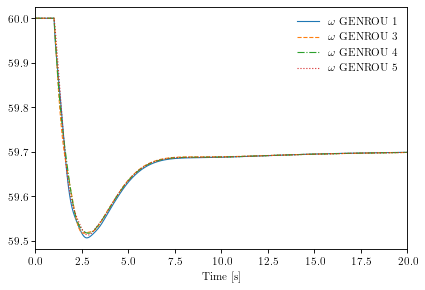

(<Figure size 480x320 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [10]:
# Show the frequency response of online generators

# Refer to `plot` documentation by using `help(ss.TDS.plt.plot)` and `help(ss.TDS.plt.plot_data)`
ss.TDS.load_plotter()

ss.TDS.plt.plot(ss.GENROU.omega,
                a=(0, 2, 3, 4),
                ytimes=60,
               )

## Adjusting Load to Compensate for the Generation Loss

Check the power of the lost generator by inspecting the power flow inputs:

In [11]:
ss.PV.as_df()

,idx,u,name,Sn,Vn,bus,busr,p0,q0,pmax,pmin,qmax,qmin,v0,vmax,vmin,ra,xs
uid,,,,,,,,,,,,,,,,,,
0,2,0.0,2,100.0,69.0,2,None,0.40,0.15,0.5,0.1,0.15,-0.40,1.03,1.4,0.6,0.0,0.13
1,3,0.0,3,100.0,69.0,3,None,0.40,0.15,0.5,0.1,0.15,-0.10,1.01,1.4,0.6,0.0,0.13
2,4,0.0,4,100.0,138.0,6,None,0.30,0.10,0.5,0.1,0.10,-0.06,1.03,1.4,0.6,0.0,0.12
3,5,0.0,5,100.0,69.0,8,None,0.35,0.10,0.5,0.1,0.10,-0.06,1.03,1.4,0.6,0.0,0.12


The tripped GENROU_2 correspond to the first PV (GENROU_1 corresponds to Slack). Thus, the lost active power is 0.40 pu.

Let's compensate for that by shedding 0.4 pu of active power load at t=2.0 s.

By checking the equation documentation of PQ (using `print(ss.PQ.doc())`, we can tell that the imposed active power for time-domain simulation is from `Ppf`, because we used the constant power model with `p2p = 1`.

```
Algebraic Equations

Name |   Type   |                RHS of Equation "0 = g(x, y)"                
-----+----------+-------------------------------------------------------------
 a   | ExtAlgeb | u * (dae_t <= 0) * (p0 * vcmp_zi + Rlb * vcmp_zl * v**2 +   
     |          | Rub * vcmp_zu * v**2) + u * (dae_t > 0) * (p2p * Ppf + p2i *
     |          | Ipeq * v + p2z * Req * v**2)                                
 v   | ExtAlgeb | u * (dae_t <= 0) * (q0 * vcmp_zi + Xlb * vcmp_zl * v**2 +   
     |          | Xub * vcmp_zu * v**2) + u * (dae_t > 0) * (q2q * Qpf + q2i *
     |          | Iqeq * v + q2z * Xeq * v**2)                                

```

`Ppf` may be different from `p0` specified in the data file.

In [12]:
# active power from power flow solution - make a copy

Ppf = np.array(ss.PQ.Ppf.v)

Ppf

array([0.217, 0.5  , 0.478, 0.076, 0.15 , 0.295, 0.09 , 0.035, 0.061,
       0.135, 0.2  ])

Reload the system and add the generator trip.

In [13]:
ss = andes.load(ieee14_raw, addfile=ieee14_dyr, setup=False)

ss.add("Toggle", dict(model='SynGen', dev="GENROU_2", t=1.0))
ss.setup()
ss.Toggle.u.v[[0, 1]] = 0

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.PFlow.run()

Working directory: "/home/hacui/repos/andes/examples"
> Loaded config from file "/home/hacui/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Parsing input file "/home/hacui/repos/andes/andes/cases/ieee14/ieee14.raw"...
  IEEE 14 BUS TEST CASE
  03/06/14 CONTO           100.0  1962 W
Input file parsed in 0.0047 seconds.
Parsing additional file "/home/hacui/repos/andes/andes/cases/ieee14/ieee14.dyr"...
Addfile parsed in 0.1101 seconds.
IEEEST <IEEEST_1> added BusFreq <BusFreq_1> linked to bus <3.0>
ST2CUT <ST2CUT_2> added BusFreq <BusFreq_2> linked to bus <1.0>
ST2CUT <ST2CUT_3> added BusFreq <BusFreq_3> linked to bus <2.0>
System internal structure set up in 0.0547 seconds.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0040 seconds.


True

But let's run to 2 seconds.

In [14]:
ss.TDS.config.tf = 2.0
ss.TDS.config.criteria = 0  # temporarily turn off stability criteria based on angle separation

ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-2.0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggle_3>: SynGen.GENROU_2 status changed to 0 at t=1.0 sec.


Simulation completed in 0.2567 seconds.
Outputs to "ieee14_out.lst" and "ieee14_out.npz".
Outputs written in 0.0043 seconds.


True

In [15]:
# all `Ppf` before shedding

ss.PQ.Ppf.v

array([0.217, 0.5  , 0.478, 0.076, 0.15 , 0.295, 0.09 , 0.035, 0.061,
       0.135, 0.2  ])

And then apply the load shedding on buses 2, 3, 4, 5, 6, 9.

In [16]:
shed_buses = [2, 3, 4, 5, 6, 9]

# find the `idx` of the loads on these buses

pq_shed_idx = ss.PQ.find_idx(keys='bus', values=shed_buses)
pq_shed_idx

['PQ_1', 'PQ_2', 'PQ_3', 'PQ_4', 'PQ_5', 'PQ_6']

In [17]:
# get `Ppf` on these buses before shedding

pq_p = ss.PQ.get(src='Ppf', idx=pq_shed_idx, attr='v')
pq_p

array([0.217, 0.5  , 0.478, 0.076, 0.15 , 0.295])

In [18]:
pq_p_new = pq_p - 0.4 / len(shed_buses)

ss.PQ.set(src='Ppf', idx=pq_shed_idx, attr='v', value=pq_p_new)

True

In [19]:
# double check

ss.PQ.Ppf.v

array([0.15033333, 0.43333333, 0.41133333, 0.00933333, 0.08333333,
       0.22833333, 0.09      , 0.035     , 0.061     , 0.135     ,
       0.2       ])

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 1.2884 seconds.
Outputs to "ieee14_out.lst" and "ieee14_out.npz".
Outputs written in 0.0211 seconds.


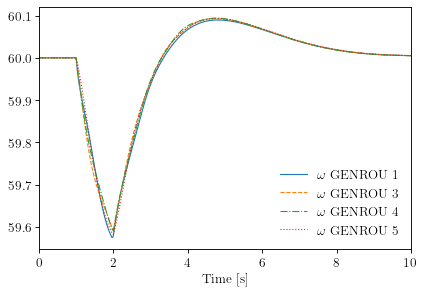

(<Figure size 480x320 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [20]:
ss.TDS.config.tf = 10

ss.TDS.run()

ss.TDS.plt.plot(ss.GENROU.omega,
                a=(0, 2, 3, 4),
                ytimes=60,
               )

In [21]:
!andes misc -C

"/home/hacui/repos/andes/examples/ieee14_out.txt" removed.
"/home/hacui/repos/andes/examples/ieee14_out.lst" removed.
"/home/hacui/repos/andes/examples/ieee14_out.npz" removed.


The result shows the generator speed (frequency) returns to 60 Hz after load shedding. 